In [ ]:
#scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Load the dataset from Excel
data = pd.read_csv('services.csv')
#data = pd.read_excel('customer_logN.xlsx')
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time
0,5,01/08/2016,73,65,finished,person,False,11:17:23,12:15:04,12:22:44,NaN,109,D,0:57:41
1,5,01/08/2016,73,224,finished,company,False,13:10:57,14:16:46,14:17:54,NaN,109,D,1:05:49
2,6,01/08/2016,34,259,finished,person,False,13:36:52,13:48:33,13:51:33,NaN,3,D,0:11:41
3,25,01/08/2016,6,40,finished,person,False,10:58:16,11:25:34,11:25:44,NaN,11,E,0:27:18
4,25,01/08/2016,6,67,finished,person,False,11:54:41,12:34:12,12:34:51,3184.0,11,E,0:39:31


In [ ]:
# Convert arrival time, waiting time, and service time to minutes
data['arrival_time'] = pd.to_datetime(data['arrival_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['arrival_time'], format='%H:%M:%S').dt.minute
data['start_time'] = pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.minute + pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.second/60
data['end_time'] = pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.minute + pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.second/60
data['waiting_time'] = pd.to_datetime(data['waiting_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['waiting_time'], format='%H:%M:%S').dt.minute
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data['date'] = data['date'].astype(int)
data.drop(columns=['client_id'], inplace=True)


In [ ]:
encoder = LabelEncoder()
data['priority'] = encoder.fit_transform(data['priority'])
data['entity'] = encoder.fit_transform(data['entity'])
data['service_type'] = encoder.fit_transform(data['service_type'])
data['status'] = encoder.fit_transform(data['status'])
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,cashier,service_type,waiting_time
0,5,1470009600000000000,73,65,0,1,0,677,735.066667,742.733333,109,2,57
1,5,1470009600000000000,73,224,0,0,0,790,856.766667,857.900000,109,2,65
2,6,1470009600000000000,34,259,0,1,0,816,828.550000,831.550000,3,2,11
3,25,1470009600000000000,6,40,0,1,0,658,685.566667,685.733333,11,3,27
4,25,1470009600000000000,6,67,0,1,0,714,754.200000,754.850000,11,3,39


In [ ]:
# Define a custom function to calculate queue length
def calculate_queue_length(row, data):
    return data[(data['date'] == row['date']) &
        (data['queue_id'] == row['queue_id']) &
        (data['branch_id'] == row['branch_id']) &
        (data['arrival_time'] < row['start_time'])]['arrival_time'].count()

# Apply the custom function to each row
data['queue_length'] = data.apply(calculate_queue_length, axis=1, data=data)
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,cashier,service_type,waiting_time,queue_length
0,5,1470009600000000000,73,65,0,1,0,677,735.066667,742.733333,109,2,57,1
1,5,1470009600000000000,73,224,0,0,0,790,856.766667,857.900000,109,2,65,2
2,6,1470009600000000000,34,259,0,1,0,816,828.550000,831.550000,3,2,11,1
3,25,1470009600000000000,6,40,0,1,0,658,685.566667,685.733333,11,3,27,1
4,25,1470009600000000000,6,67,0,1,0,714,754.200000,754.850000,11,3,39,2


In [ ]:
x = data[['branch_id','date','queue_id','sequence','status','entity','priority','arrival_time','cashier','service_type','queue_length']]
y = data['waiting_time']

In [ ]:
# Scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

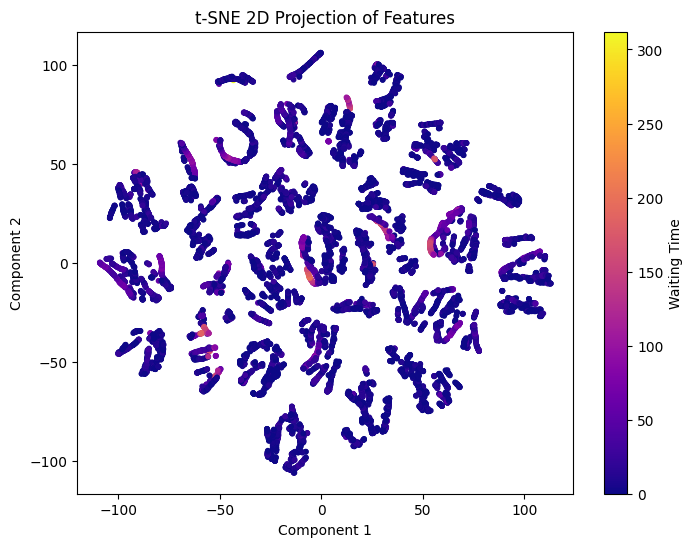

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(x)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='plasma', s=10)
plt.colorbar(label='Waiting Time')
plt.title("t-SNE 2D Projection of Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Use the 2D t-SNE components as features
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("RMSE",(np.sqrt(mean_squared_error(y_test,y_pred))))
print("r2", r2_score(y_test, y_pred))


MAE 4.566522423288748
MSE 67.40145837922896
RMSE 8.209839120179454
r2 0.8780716294997802


In [ ]:
# Train Random Forest
et = ExtraTreesRegressor(n_estimators=100, random_state=42)
et.fit(X_train, y_train)

# Predict and evaluate
y_pred = et.predict(X_test)
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("RMSE",(np.sqrt(mean_squared_error(y_test,y_pred))))
print("r2", r2_score(y_test, y_pred))

MAE 3.94256884343037
MSE 51.6994333202203
RMSE 7.19023179878231
r2 0.9064763906879824


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

input_dim = x_scaled.shape[1]

# Define encoder-decoder structure
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)  # Bottleneck: compressed features
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Fit the model
autoencoder.fit(x_scaled, x_scaled, epochs=100, batch_size=16, shuffle=True, validation_split=0.2,random_state=42)


Epoch 1/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8937 - val_loss: 0.7386
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4864 - val_loss: 0.6627
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4122 - val_loss: 0.6427
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3763 - val_loss: 0.6050
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3570 - val_loss: 0.5306
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3324 - val_loss: 0.4999
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3069 - val_loss: 0.5104
Epoch 8/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2958 - val_loss: 0.4946
Epoch 9/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2952 - val_loss: 0.5042
Epoch 10/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2809 - val_loss: 0.5015
Epoch 11/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2661 - val_loss: 0.4718
Epoch 12/100
636/636 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
X_compressed = encoder.predict(x_scaled)


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:

from sklearn.metrics import mean_squared_error

# Split data (optional)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_compressed, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("RMSE",(np.sqrt(mean_squared_error(y_test,y_pred))))
print("r2", r2_score(y_test, y_pred))


MAE 6.0409520062942565
MSE 114.28431715184894
RMSE 10.69038433134417
r2 0.7932611415371179


In [ ]:
# Train model
model = ExtraTreesRegressor(n_estimators = 100)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("RMSE",(np.sqrt(mean_squared_error(y_test,y_pred))))
print("r2", r2_score(y_test, y_pred))

MAE 5.082612116443745
MSE 91.64150479937057
RMSE 9.572956951714062
r2 0.8342216975854233
